In [1]:
import numpy as np
import pandas as pd
import plotly.express as px

color = px.colors.sequential.Rainbow[::-1]
marker_size = 2

def plot_3D (exp_name , depth_axis):
    my_sample_x = np.loadtxt("3D_Experements/"+exp_name+"_x.txt")
    my_sample_y = np.loadtxt("3D_Experements/"+exp_name+"_y.txt")
    my_sample_z = np.loadtxt("3D_Experements/"+exp_name+"_z.txt")
    df = pd.DataFrame(my_sample_x,columns=['X (mm)'])
    df['Y (mm)'] = my_sample_y
    df['Z (mm)'] = my_sample_z
    df.head()
    min_depth = 0
    max_depth = 0
    if depth_axis == 'x':
        df['Depth'] = my_sample_x
        max_depth = np.amax(my_sample_x)
        min_depth = np.amin(my_sample_x)

    elif depth_axis == 'y':
        df['Depth'] = my_sample_y
        max_depth = np.amax(my_sample_y)
        min_depth = np.amin(my_sample_y)

    elif depth_axis == 'z':
        df['Depth'] = my_sample_z
        max_depth = np.amax(my_sample_z)
        min_depth = np.amin(my_sample_z)
        

    else:
        print("invalid depth axis")
        return

    fig = px.scatter_3d(df, x='X (mm)', y='Y (mm)', z='Z (mm)', color='Depth', title="ٌRadar Point Cloud" , range_color=[min_depth,max_depth],color_continuous_scale=color , opacity=1)
    fig.update_traces(marker=dict(size=marker_size, line=dict(width=0))) 
    fig.show()



In [2]:
import numpy as np
import pandas as pd
import plotly.express as px

color = px.colors.sequential.Rainbow[::-1]
marker_size = 2

def plot_3D (exp_name , depth_axis):
    dist = np.loadtxt("3D_Experements/"+exp_name+"_x.txt")
    upper_angle = np.loadtxt("3D_Experements/"+exp_name+"_y.txt")
    lower_angle = np.loadtxt("3D_Experements/"+exp_name+"_z.txt")

    # print("print upper_angle = "+upper_angle)
    #x , y , z = np.array(dist)*np.cos(uAngel)*np.sin(lAngel) , np.array(dist)*np.cos(uAngel)*np.cos(lAngel) , np.array(dist)*np.sin(uAngel)

    my_sample_x = np.array(dist)*np.cos(upper_angle)*np.sin(lower_angle)
    my_sample_y =  np.array(dist)*np.cos(upper_angle)*np.cos(lower_angle)
    my_sample_z =  np.array(dist)*np.sin(upper_angle)

    df = pd.DataFrame(my_sample_x,columns=['X (mm)'])
    df['Y (mm)'] = my_sample_y
    df['Z (mm)'] = my_sample_z
    df.head()
    min_depth = 0
    max_depth = 0
    if depth_axis == 'x':
        df['Depth'] = my_sample_x
        max_depth = np.amax(my_sample_x)
        min_depth = np.amin(my_sample_x)

    elif depth_axis == 'y':
        df['Depth'] = my_sample_y
        max_depth = np.amax(my_sample_y)
        min_depth = np.amin(my_sample_y)

    elif depth_axis == 'z':
        df['Depth'] = my_sample_z
        max_depth = np.amax(my_sample_z)
        min_depth = np.amin(my_sample_z)
        

    else:
        print("invalid depth axis")
        return
   

    fig = px.scatter_3d(df, x='X (mm)', y='Y (mm)', z='Z (mm)', color='Depth', title="ٌRadar Point Cloud" , range_color=[min_depth-200,max_depth+200],color_continuous_scale=color , opacity=1)
    fig.update_traces(marker=dict(size=marker_size, line=dict(width=0))) 
    fig.show()



# 1 ) Corner mapping experement
![title](img/corner.jpg)


In [ ]:
plot_3D("3D_corner",'y')
plot_3D("3D_corner",'z')

In [ ]:
plot_3D("3D_corner(1)",'y')
plot_3D("3D_corner(1)",'z')

# 2 ) Cylinder mapping experement
![title](img/cylinder.jpg)


In [ ]:
plot_3D("3D_cylinder",'y')
plot_3D("3D_cylinder",'z')

In [ ]:
plot_3D("3D_cylinder(1)",'y')
plot_3D("3D_cylinder(1)",'z')

# 3 ) Body mapping experement
![title](img/ezzat_body.jpg)


In [ ]:
plot_3D("3D_ezzat_body",'y')
plot_3D("3D_ezzat_body",'z')

# 4 ) Face mapping experement
![title](img/ezzat_face.jpg)


In [ ]:
plot_3D("3D_ezzat_face",'y')
plot_3D("3D_ezzat_face",'z')

In [ ]:
plot_3D("waleed_face",'y')
plot_3D("waleed_face",'z')

In [ ]:
plot_3D("wall",'y')
plot_3D("wall",'z')

In [ ]:
#50
plot_3D("wall1",'y')
plot_3D("wall1",'z')

In [ ]:
#50
plot_3D("wall2",'y')
plot_3D("wall2",'z')

In [ ]:
#50
plot_3D("wall4",'y')
# plot_3D("wall4",'z')

In [ ]:
#50
plot_3D("wall4d",'y')
plot_3D("wall4d",'z')

In [ ]:
#50
plot_3D("wall7",'y')
plot_3D("wall7",'z')

In [ ]:
plot_3D("hello3",'y')
plot_3D("hello3",'z')

In [65]:
import numpy as np
from plotly import offline
from plotly import graph_objs as go
import torch
from PIL import Image
import plotly.express as px
import cv2
import pandas as pd
import matplotlib.pyplot as plt
color = px.colors.sequential.Rainbow[::-1]
marker_size = 3

def points_to_image(exp_name,threshold):
    dist = np.loadtxt("3D_Experements/"+exp_name+"_x.txt")
    upper_angle = np.loadtxt("3D_Experements/"+exp_name+"_y.txt")
    lower_angle = np.loadtxt("3D_Experements/"+exp_name+"_z.txt")

    print(np.amax(upper_angle*180/np.pi))
    print(np.amin(upper_angle*180/np.pi))
    print(np.amax(lower_angle*180/np.pi))
    print(np.amin(lower_angle*180/np.pi))
    

    #x , y , z = np.array(dist)*np.cos(uAngel)*np.sin(lAngel) , np.array(dist)*np.cos(uAngel)*np.cos(lAngel) , np.array(dist)*np.sin(uAngel)

    my_sample_x = np.array(dist)*np.cos(upper_angle)*np.sin(lower_angle)
    my_sample_y =  np.array(dist)*np.cos(upper_angle)*np.cos(lower_angle)
    my_sample_z =  np.array(dist)*np.sin(upper_angle)
    
    my_sample_x = my_sample_x[~np.isnan(my_sample_x)]
    my_sample_y = my_sample_y[~np.isnan(my_sample_y)]
    my_sample_z = my_sample_z[~np.isnan(my_sample_z)]

    
    min_depth = np.amin(my_sample_y)
    max_depth = (min_depth + threshold)
    indx = my_sample_y <= (min_depth + threshold)

    my_sample_x = my_sample_x[indx]
    my_sample_y = my_sample_y[indx]
    my_sample_z = my_sample_z[indx]
    
   
    
    
    
    
    
    my_sample_y = 1-  my_sample_y / np.max(my_sample_y)
    

    x_min = np.min(my_sample_x)
    x_max = np.max(my_sample_x)
    y_min = np.min(my_sample_y)
    y_max = np.max(my_sample_y)
    z_min = np.min(my_sample_z)
    z_max = np.max(my_sample_z)
    width = 1+(x_max - x_min).astype(int)
    hight = 1+(z_max - z_min).astype(int)

    # my_sample_y = my_sample_y + (1-y_max)
    print("img :: ",width,hight)
    img = np.zeros((width,hight))
    
    for i in range(len(my_sample_x)):
        x = (my_sample_x[i] - x_min).astype(int)
        z = (my_sample_z[i] - z_min).astype(int)
#         print("x,z :: ",x,z)
        img[x,z] = my_sample_y[i]
        
#     img = Image.fromarray(img)
    print(len(my_sample_x))
    
    kernel = np.ones((5,5), np.uint8)
 
    # The first parameter is the original image,
    # kernel is the matrix with which image is
    # convolved and third parameter is the number
    # of iterations, which will determine how much
    # you want to erode/dilate a given image.
    img_erosion = cv2.erode(img, kernel, iterations=1)
    img_dilation = cv2.dilate(img, kernel, iterations=5)

    cv2.imshow('Input', img)
    cv2.imshow('Erosion', img_erosion)
    cv2.imshow('Dilation', img_dilation)

    cv2.waitKey(0)
#     img.show()
    
def plot_3D (exp_name , depth_axis):
    dist = np.loadtxt("3D_Experements/"+exp_name+"_x.txt")
    upper_angle = np.loadtxt("3D_Experements/"+exp_name+"_y.txt")
    lower_angle = np.loadtxt("3D_Experements/"+exp_name+"_z.txt")

    print(np.amax(upper_angle*180/np.pi))
    print(np.amin(upper_angle*180/np.pi))
    print(np.amax(lower_angle*180/np.pi))
    print(np.amin(lower_angle*180/np.pi))
    

    #x , y , z = np.array(dist)*np.cos(uAngel)*np.sin(lAngel) , np.array(dist)*np.cos(uAngel)*np.cos(lAngel) , np.array(dist)*np.sin(uAngel)

    my_sample_x = np.array(dist)*np.cos(upper_angle)*np.sin(lower_angle)
    my_sample_y =  np.array(dist)*np.cos(upper_angle)*np.cos(lower_angle)
    my_sample_z =  np.array(dist)*np.sin(upper_angle)
    
    my_sample_x = my_sample_x[~np.isnan(my_sample_x)]
    my_sample_y = my_sample_y[~np.isnan(my_sample_y)]
    my_sample_z = my_sample_z[~np.isnan(my_sample_z)]

    df = pd.DataFrame(my_sample_x,columns=['X (mm)'])
    df['Y (mm)'] = my_sample_y
    df['Z (mm)'] = my_sample_z
    df.head()
    min_depth = 0
    max_depth = 0
    if depth_axis == 'x':
        df['Depth'] = my_sample_x
        max_depth = np.amax(my_sample_x)
        min_depth = np.amin(my_sample_x)

    elif depth_axis == 'y':
        df['Depth'] = my_sample_y
        max_depth = np.amax(my_sample_y)
        min_depth = np.amin(my_sample_y)

    elif depth_axis == 'z':
        df['Depth'] = my_sample_z
        max_depth = np.amax(my_sample_z)
        min_depth = np.amin(my_sample_z)
        

    else:
        print("invalid depth axis")
        return
   

    fig = px.scatter_3d(df, x='X (mm)', y='Y (mm)', z='Z (mm)', color='Depth', title="ٌRadar Point Cloud" , range_color=[min_depth-200,max_depth+200],color_continuous_scale=color , opacity=1)
    fig.update_traces(marker=dict(size=marker_size, line=dict(width=0))) 
    fig.show()
    
    
def plot_3D_threshold (exp_name ,folder_indx , depth_axis ,threshold):
    folder = ["3D_Experements", "flat_Experements"]
    dist = np.loadtxt(folder[folder_indx]+"/"+exp_name+"_x.txt")
    upper_angle = np.loadtxt(folder[folder_indx]+"/"+exp_name+"_y.txt")
    lower_angle = np.loadtxt(folder[folder_indx]+"/"+exp_name+"_z.txt")

    print(np.amax(upper_angle*180/np.pi))
    print(np.amin(upper_angle*180/np.pi))
    print(np.amax(lower_angle*180/np.pi))
    print(np.amin(lower_angle*180/np.pi))
    

    #x , y , z = np.array(dist)*np.cos(uAngel)*np.sin(lAngel) , np.array(dist)*np.cos(uAngel)*np.cos(lAngel) , np.array(dist)*np.sin(uAngel)

    my_sample_x = np.array(dist)*np.cos(upper_angle)*np.sin(lower_angle)
    my_sample_y =  np.array(dist)*np.cos(upper_angle)*np.cos(lower_angle)
    my_sample_z =  np.array(dist)*np.sin(upper_angle)
    my_sample_x = my_sample_x[~np.isnan(my_sample_x)]
    my_sample_y = my_sample_y[~np.isnan(my_sample_y)]
    my_sample_z = my_sample_z[~np.isnan(my_sample_z)]

    df = pd.DataFrame()
    
    indx = []
    min_depth = 0
    max_depth = 0
    if depth_axis == 'x':
        min_depth = np.amin(my_sample_x)
        max_depth = threshold#(min_depth + threshold)
        indx = my_sample_x<= threshold#(min_depth + threshold)
        df['Depth'] = my_sample_x[indx]

    elif depth_axis == 'y':
        min_depth = np.amin(my_sample_y)
        max_depth = threshold#(min_depth + threshold)
        indx = my_sample_y <= threshold#(min_depth + threshold)
#         print(my_sample_y , (min_depth + threshold))
#         print(type(my_sample_y),type(my_sample_y[indx]))
        df['Depth'] = my_sample_y[indx]

    elif depth_axis == 'z':
        min_depth = np.amin(my_sample_z)
        max_depth = threshold#(min_depth + threshold)
        indx = my_sample_z<= threshold#(min_depth + threshold)
        df['Depth'] = my_sample_z[indx]
        

    else:
        print("invalid depth axis")
        return
    df['X (mm)'] = my_sample_x[indx]
    df['Y (mm)'] = my_sample_y[indx]
    df['Z (mm)'] = my_sample_z[indx]
    df.head()
   

    # fig = px.scatter_3d(df, x='X (mm)', y='Y (mm)', z='Z (mm)', color='Depth', title="ٌRadar Point Cloud" , range_color=[min_depth,max_depth], range_y=[300,700],color_continuous_scale=color , opacity=1)
    fig = px.scatter_3d(df, x='X (mm)', y='Y (mm)', z='Z (mm)', color='Depth', title="ٌRadar Point Cloud" , range_color=[min_depth,max_depth],color_continuous_scale=color , opacity=1)
    fig.update_traces(marker=dict(size=marker_size, line=dict(width=0))) 
    fig.show()


def plot_2D (exp_name):
    dist = np.loadtxt("3D_Experements/"+exp_name+"_x.txt")
    upper_angle = np.loadtxt("3D_Experements/"+exp_name+"_y.txt")
    lower_angle = np.loadtxt("3D_Experements/"+exp_name+"_z.txt")

    print(np.amax(upper_angle*180/np.pi))
    print(np.amin(upper_angle*180/np.pi))
    print(np.amax(lower_angle*180/np.pi))
    print(np.amin(lower_angle*180/np.pi))
    

    #x , y , z = np.array(dist)*np.cos(uAngel)*np.sin(lAngel) , np.array(dist)*np.cos(uAngel)*np.cos(lAngel) , np.array(dist)*np.sin(uAngel)

    my_sample_x = np.array(dist)*np.cos(upper_angle)*np.sin(lower_angle)
    my_sample_y =  np.array(dist)*np.cos(upper_angle)*np.cos(lower_angle)
    my_sample_z =  np.array(dist)*np.sin(upper_angle)

    minx = np.min(my_sample_x)
    miny = np.min(my_sample_y)
    minz = np.min(my_sample_z)

    maxx = np.max(my_sample_x)
    maxy = np.max(my_sample_y)
    maxz = np.max(my_sample_z)

    # img =np.zeros(int(maxx-minx),int(maxz-minz))
    # img =np.zeros((int(maxx-minx),int(maxz-minz)), dtype=np.float64)
    # img =np.zeros(len(my_sample_x),len(my_sample_z)), dtype=np.float64)

    # for i in range(len(my_sample_x) - 1):
    #     img[int(my_sample_x[i] - minx -1)][int(my_sample_z[i] - minz -1)] = (my_sample_y[i] / maxy)*255
    
    trace = go.Surface(x = my_sample_x, y = my_sample_y, z =my_sample_z )
    data = [trace]
    layout = go.Layout(title = '3D Surface plot')
    fig = go.Figure(data = data)
    plot(fig)
    offline.init_notebook_mode(connected=False)

    df3 = {'x':[1, 2, 3, 4, 5],'y':[10, 20, 30, 40, 50],'z': [[5, 4, 3, 2, 1]]*5}
    offline.iplot(dict(data=[go.Surface(x=df3['x'], y=df3['y'], z=df3['z'])]))

def plot_var(threshold):
    exp_p = ["gedo_14_7",
             "waleed_14_7",
             "ta7a_14_7",
             "nassar_14_7"]

    exp_n = ["metal_dish",
            "painting"]

    var_all = []
    count = 0
    color = []

    for i in range(len(exp_p)):
        for j in range(1000):
            exp_name = exp_p[i] + "_" + str(j)
            dist = np.loadtxt("3D_Experements/"+exp_name+"_x.txt")
            upper_angle = np.loadtxt("3D_Experements/"+exp_name+"_y.txt")
            lower_angle = np.loadtxt("3D_Experements/"+exp_name+"_z.txt")
            my_sample_y =  np.array(dist)*np.cos(upper_angle)*np.cos(lower_angle)

            min_depth = np.amin(my_sample_y)
            max_depth = (min_depth + threshold)
            indx = my_sample_y <= (min_depth + threshold)
            my_sample_y = my_sample_y[indx]
            var_all.append(np.var(my_sample_y))
            count+=1
            color.append(0)
            # print(count)

    
    for i in range(len(exp_n)):
        for j in range(1000):
            exp_name = exp_n[i] + "_" + str(j)
            dist = np.loadtxt("flat_Experements/"+exp_name+"_x.txt")
            upper_angle = np.loadtxt("flat_Experements/"+exp_name+"_y.txt")
            lower_angle = np.loadtxt("flat_Experements/"+exp_name+"_z.txt")
            my_sample_y =  np.array(dist)*np.cos(upper_angle)*np.cos(lower_angle)
            # var_all.append(np.var(my_sample_y))

            min_depth = np.amin(my_sample_y)
            max_depth = (min_depth + threshold)
            indx = my_sample_y <= (min_depth + threshold)
            my_sample_y = my_sample_y[indx]
            var_all.append(np.var(my_sample_y))
            color.append(1)
            count+=1
            # print(count)

    x = [num for num in range(0, len(var_all), 1)]
    # a = np.array([x,var_all])

    categories = np.array(color)

    colormap = np.array(['g', 'r'])

    plt.scatter(np.array(x), np.array(var_all), s=100, c=colormap[categories])

    # plt.savefig('ScatterClassPlot.png')
    # plt.show()
     
    
    # plt.plot(x, var_all,'o',color = color)
    plt.xlabel('X')
    plt.ylabel('var')
    plt.grid(True)

    plt.plot()
from skimage.filters import threshold_minimum

min_dist = 200
max_dist=800
bin_size = 10
def plot_hist(exp_name,folder_indx):
    np.seterr(divide='ignore', invalid='ignore')
    folder = ["3D_Experements", "flat_Experements"]
    dist = np.loadtxt(folder[folder_indx]+"/"+exp_name+"_x.txt")
    upper_angle = np.loadtxt(folder[folder_indx]+"/"+exp_name+"_y.txt")
    lower_angle = np.loadtxt(folder[folder_indx]+"/"+exp_name+"_z.txt")

    my_sample_y =  np.array(dist)*np.cos(upper_angle)*np.cos(lower_angle)
    # plt.hist(my_sample_y , bins = [i for i in range(200,800,10)]) 
    # plt.title("histogram") 
    # thresh_min = threshold_minimum(my_sample_y)
    # print(thresh_min)
    # plt.axvline(thresh_min, color='r')
    # plt.show()  

    #######################################
    


    # Set total number of bins in the histogram
    bins_num = [i for i in range(min_dist,max_dist,bin_size)]#256

    
    # Get the image histogram
    n = plt.hist(my_sample_y , bins = bins_num) 
    hist = n[0]
    bin_edges = n[1]
    
    # Get normalized histogram if it is required
    # if is_normalized:
    #     hist = np.divide(hist.ravel(), hist.max())

    # Calculate centers of bins
    bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2.
    
    # print ("bin_edges[:-1]" , bin_edges[:-1])
    # print ("bin_edges[1:]", bin_edges[1:])
    # Iterate over all thresholds (indices) and get the probabilities w1(t), w2(t)
    weight1 = np.cumsum(hist)
    
    weight2 = np.cumsum(hist[::-1])[::-1]
    
    # Get the class means mu0(t)
    mean1 = np.cumsum(hist * bin_mids) / weight1
    # Get the class means mu1(t)
    mean2 = (np.cumsum((hist * bin_mids)[::-1]) / weight2[::-1])[::-1]

    mean1 = np.nan_to_num(mean1)
    mean2 = np.nan_to_num(mean2)
    

    
    inter_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2

    # Maximize the inter_class_variance function val
    index_of_max_val = np.argmax(inter_class_variance)

    threshold = bin_mids[:-1][index_of_max_val]
    print("Otsu's algorithm implementation thresholding result: ", threshold)

    
    plt.title("histogram") 
    plt.axvline(threshold, color='r')
    plt.show()
     
    return threshold,hist,bin_edges
    


Otsu's algorithm implementation thresholding result:  645.0


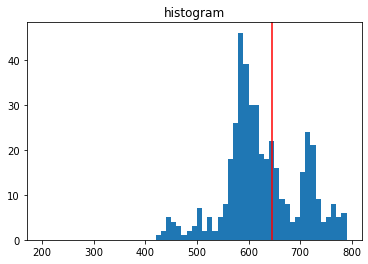

[200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370
 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550
 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730
 740 750 760 770 780 790]
645.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 5.0, 4.0, 3.0, 1.0, 2.0, 3.0, 7.0, 2.0, 5.0, 2.0, 5.0, 8.0, 18.0, 26.0, 46.0, 39.0, 30.0, 30.0, 19.0, 18.0, 22.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [84]:
# plot_3D("waleed2_12_7",'y')\
# plot_3D_threshold("ta7a_14_7_20",0,'y',100000)
# plot_3D_threshold("metal_dish_20",1,'y',1000000)
# points_to_image("ta7a_14_7_20",90)
# plot_hist("nassar_14_7_20",0)
# plot_hist("painting_20",1)

# plot_3D_threshold("ta7a_14_7_200",0,'y',plot_hist("ta7a_14_7_200",0)[0])
# plot_3D_threshold("painting_200",1,'y',plot_hist("painting_200",1)[0])
t , h, e = plot_hist("Ball_60cm_200",1)
print(e)
print(t)
# print(len(h[1][indx[:len(indx)]]))
his = [ h[i] if e[i] < t else 0 for i in range(h.size)]
print(his)
# print(len(h[2]))
# h = [ h[i] if i <= t else 0 for i in range(len(h))]



In [63]:
feature_hist_ = []
target_list_ = []
feature_hist_.append(his)
target_list_.append(1)

In [83]:
plot_3D_threshold("Ball_60cm_200",1,'y',1000)

18.0
-18.0
18.0
-18.0


Otsu's algorithm implementation thresholding result:  565.0


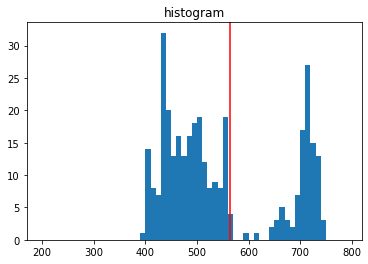

count ::  1
Otsu's algorithm implementation thresholding result:  565.0


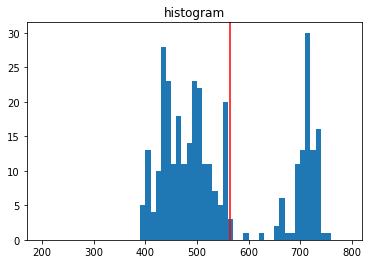

count ::  2
Otsu's algorithm implementation thresholding result:  595.0


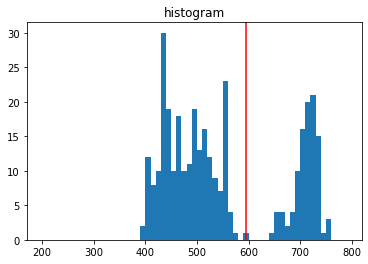

count ::  3
Otsu's algorithm implementation thresholding result:  575.0


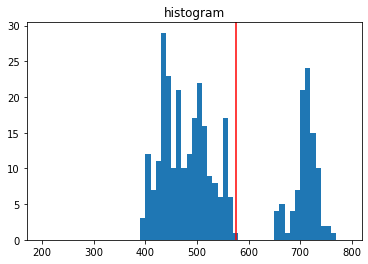

count ::  4
Otsu's algorithm implementation thresholding result:  595.0


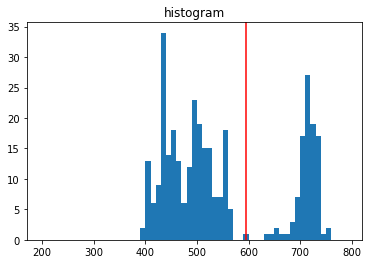

count ::  5
Otsu's algorithm implementation thresholding result:  595.0


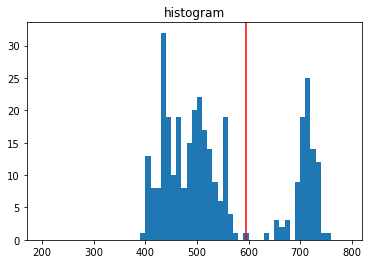

count ::  6
Otsu's algorithm implementation thresholding result:  565.0


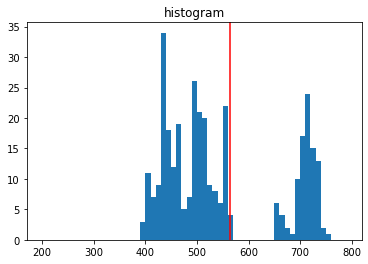

count ::  7
Otsu's algorithm implementation thresholding result:  595.0


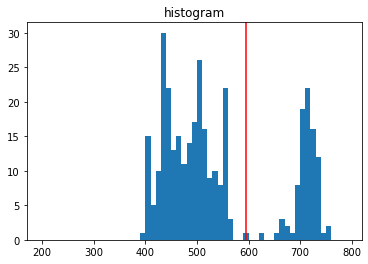

count ::  8
Otsu's algorithm implementation thresholding result:  575.0


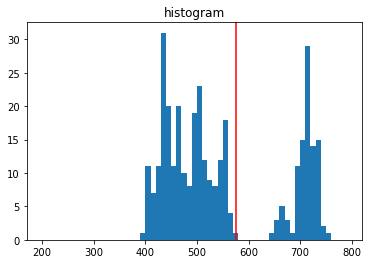

count ::  9
Otsu's algorithm implementation thresholding result:  565.0


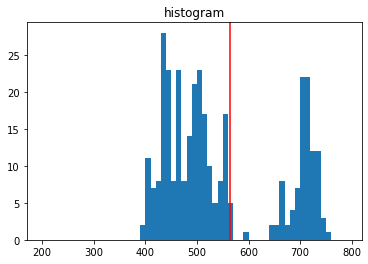

count ::  10
Otsu's algorithm implementation thresholding result:  565.0


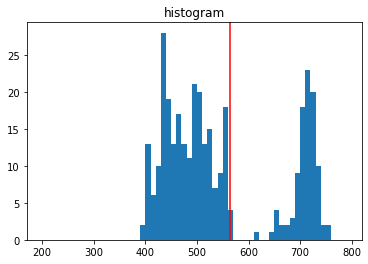

count ::  11
Otsu's algorithm implementation thresholding result:  565.0


KeyboardInterrupt: 

In [40]:
exp_p = ["gedo_14_7",
             "waleed_14_7",
             "ta7a_14_7",
             "nassar_14_7"]

exp_n = ["metal_dish",
        "painting"]
count = 0
feature_hist = []
target_list = [] 
for i in range(len(exp_p)):
    for j in range(1000):
        exp_name = exp_p[i] + "_" + str(j)
        t , h ,e = plot_hist(exp_name,0)
        f = [ h[i] if e[i] < t else 0 for i in range(h.size)]
        feature_hist.append(f)
        target_list.append(1)
        count += 1
        print("count :: ",count)


for i in range(len(exp_n)):
    for j in range(1000):
        exp_name = exp_n[i] + "_" + str(j)
        t , h,e = plot_hist(exp_name,1)
        f = [ h[i] if e[i] < t else 0 for i in range(h.size)]
        feature_hist.append(f)
        target_list.append(-1)
        count += 1
        print("count :: ",count)

feature_hist = np.array(feature_hist)
target_list = np.array(target_list)
file = open("features/feature_hist_data.txt", "a")
np.savetxt(file, feature_hist)
file.close()

file = open("features/feature_hist_target_list.txt", "a")
np.savetxt(file, target_list)
file.close()

print(len(feature_hist[0]))
print (type(feature_hist))
print (type(target_list))



In [65]:
target_list = np.loadtxt("features/feature_hist_target_list.txt")
data_list = np.loadtxt("features/feature_hist_data.txt")

In [66]:
print(data_list.shape)

(6000, 59)


In [67]:
# Import train_test_split function
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(data_list, target_list, test_size=0.3,random_state=0) # 70% training and 30% test
print (X_train)
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Accuracy: 1.0


In [68]:
# print (X_test[1600])
y_pred = clf.predict(np.array(feature_hist_))
# y_pred[1600]
print (y_pred)

[1.]


In [4]:
import numpy as np
import open3d as o3d
folder_indx = 0 
exp_name = "waleed_14_7_136"
folder = ["3D_Experements", "flat_Experements"]
dist = np.loadtxt(folder[folder_indx]+"/"+exp_name+"_x.txt")
upper_angle = np.loadtxt(folder[folder_indx]+"/"+exp_name+"_y.txt")
lower_angle = np.loadtxt(folder[folder_indx]+"/"+exp_name+"_z.txt")



#x , y , z = np.array(dist)*np.cos(uAngel)*np.sin(lAngel) , np.array(dist)*np.cos(uAngel)*np.cos(lAngel) , np.array(dist)*np.sin(uAngel)

my_sample_x = np.array(dist)*np.cos(upper_angle)*np.sin(lower_angle)
my_sample_y =  np.array(dist)*np.cos(upper_angle)*np.cos(lower_angle)
my_sample_z =  np.array(dist)*np.sin(upper_angle)
my_sample_x = my_sample_x[~np.isnan(my_sample_x)]
my_sample_y = my_sample_y[~np.isnan(my_sample_y)]
my_sample_z = my_sample_z[~np.isnan(my_sample_z)]

# print (type(my_sample_z.tolist()))

points = np.array([my_sample_x.tolist(), my_sample_y.tolist(), my_sample_z.tolist()])
print(points.shape)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points[:,:3])
# o3d.visualization.draw_geometries([pcd])
distances = pcd.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
radius = 3 * avg_dist
bpa_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd,o3d.utility.DoubleVector([radius, radius * 2]))
# o3d.visualization.draw_geometries([bpa_mesh])
o3d.visualization.draw_geometries(bpa_mesh)
# dec_mesh = o3d.geometry.simplify_quadric_decimation(100000)
# dec_mesh.remove_degenerate_triangles()
# dec_mesh.remove_duplicated_triangles()
# dec_mesh.remove_duplicated_vertices()
# dec_mesh.remove_non_manifold_edges()

(3, 336)


TypeError: draw_geometries(): incompatible function arguments. The following argument types are supported:
    1. (geometry_list: List[open3d.open3d.geometry.Geometry], window_name: str = 'Open3D', width: int = 1920, height: int = 1080, left: int = 50, top: int = 50) -> None

Invoked with: geometry::TriangleMesh with 3 points and 0 triangles.

In [3]:
import plotly.graph_objects as go
import numpy as np
  
# Data for three-dimensional scattered points
# z = 15 * np.random.random(100)
# x = np.sin(z) + 0.1 * np.random.randn(100)
# y = np.cos(z) + 0.1 * np.random.randn(100)
folder_indx = 0
exp_name = "ta7a_14_7_136"
folder = ["3D_Experements", "flat_Experements"]
dist = np.loadtxt(folder[folder_indx]+"/"+exp_name+"_x.txt")
upper_angle = np.loadtxt(folder[folder_indx]+"/"+exp_name+"_y.txt")
lower_angle = np.loadtxt(folder[folder_indx]+"/"+exp_name+"_z.txt")



#x , y , z = np.array(dist)*np.cos(uAngel)*np.sin(lAngel) , np.array(dist)*np.cos(uAngel)*np.cos(lAngel) , np.array(dist)*np.sin(uAngel)

my_sample_x = np.array(dist)*np.cos(upper_angle)*np.sin(lower_angle)
my_sample_y =  np.array(dist)*np.cos(upper_angle)*np.cos(lower_angle)
my_sample_z =  np.array(dist)*np.sin(upper_angle)
my_sample_x = my_sample_x[~np.isnan(my_sample_x)]
my_sample_y = my_sample_y[~np.isnan(my_sample_y)]
my_sample_z = my_sample_z[~np.isnan(my_sample_z)]
fig = go.Figure(data=[go.Mesh3d(x=my_sample_x, y=my_sample_y, z=my_sample_z, color='green',
                                opacity=0.80, alphahull=3)])
  
fig.show()